In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples.csv')
df.shape

CPU times: user 22.3 s, sys: 2.26 s, total: 24.5 s
Wall time: 24.5 s


(14276908, 9)

In [3]:
df.head()

,source_word,target_word,source_fn,target_fn,set_name,speaker_id,book_id,distance_from_target,audio_fpath
0,I,FELT,dc963d3c4e7f4237a7fbd873d2dd7b67,fdd98e47b54c4f55a12dde4fa61031ad,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
1,I,THAT,dc963d3c4e7f4237a7fbd873d2dd7b67,b9ea3d2912944c1d9a323b7afc8ff979,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
2,FELT,I,fdd98e47b54c4f55a12dde4fa61031ad,dc963d3c4e7f4237a7fbd873d2dd7b67,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
3,FELT,THAT,fdd98e47b54c4f55a12dde4fa61031ad,b9ea3d2912944c1d9a323b7afc8ff979,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
4,FELT,IT,fdd98e47b54c4f55a12dde4fa61031ad,320893dcd489422dab833418ff4641f9,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac


In [4]:
df = df[df.distance_from_target == 1]
df = df[(~df.target_word.isna() & ~df.source_word.isna())]
df.reset_index(inplace=True, drop=True)

In [5]:
words = np.concatenate((df.target_word, df.source_word))
vocab = np.unique(words)

In [6]:
len(vocab)

64763

In [7]:
vocab = list(df.target_word.unique())

In [8]:
# %%time

# uniq_fns = np.unique(df.target_fn.values)
# fn2feature = {}
# for fn in uniq_fns:
#     ary = pd.read_pickle(f'data/examples/{fn}.pkl')
#     fn2feature[fn] = ary

# pd.to_pickle(fn2feature, 'data/fn2feature.pkl')

In [9]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 16.9 s, sys: 10.8 s, total: 27.7 s
Wall time: 27.7 s


In [10]:
# %%time

# word2row_idxs = defaultdict(empty_list)

# for idx, row in df.iterrows():
#     word2row_idxs[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs, 'data/word2row_idxs.pkl')

In [11]:
def empty_list(): return list()
word2row_idxs = pd.read_pickle('data/word2row_idxs.pkl')

In [12]:
word2index = {word: i for i, word in enumerate(vocab)}

In [13]:
class Dataset():
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        source_word = self.df.source_word[idx]
        target_word = self.df.target_word[idx]
        return word2index[source_word], word2index[target_word]

In [14]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

train_examples.reset_index(inplace=True, drop=True)
valid_examples.reset_index(inplace=True, drop=True)

In [15]:
train_ds = Dataset(train_examples)
valid_ds = Dataset(valid_examples)

In [16]:
len(train_ds), len(valid_ds)

(7754734, 87118)

In [17]:
BS = 2048
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [18]:
class Model(Module):
    def __init__(self, hidden_size=50):
        self.embeddings =nn.Embedding(len(vocab), hidden_size)
        self.linear = nn.Linear(hidden_size, len(vocab))
            
    def forward(self, x):
        x = self.embeddings(x)
        return self.linear(x)

In [19]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [20]:
learn.fit(120, lr=1e-3, cbs=SaveModelCallback(fname='text_embeddings', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,6.541406,6.600399,0.101253,02:05
1,6.302827,6.414139,0.110069,02:06
2,6.222527,6.342368,0.113077,02:06
3,6.174917,6.301430,0.116566,02:05
4,6.138557,6.273569,0.117289,02:08
5,6.117006,6.252335,0.118529,02:09
6,6.092341,6.235180,0.119022,02:07
7,6.080398,6.222409,0.119826,02:08
8,6.047434,6.209677,0.120124,02:06
9,6.032479,6.199724,0.120985,02:06


## Evalute embeddings

In [21]:
from utils import Embeddings

In [22]:
embeddings = learn.model.embeddings.weight.cpu().detach().numpy()

In [23]:
word2embedding_without_nans= {}
nans_encountered = 0
for i in range(len(vocab)):    
    if vocab[i] == vocab[i]:
        word2embedding_without_nans[vocab[i]] = embeddings[i]
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

Encountered rows with nan values: 0


In [24]:
e = Embeddings(
    np.array(list(word2embedding_without_nans.values())),
    [w.lower() for w in list(word2embedding_without_nans.keys())]
)

In [25]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'hard', 'heavily', 'promiscuously', 'aphrodite']
lost: ['lost', 'relinquished', 'regained', 'cleared', 'caught']
small: ['small', 'large', 'big', 'little', 'tiny']
true: ['true', 'noble', 'shocking', 'christian', 'indigenous']
crazy: ['crazy', 'unborn', 'deaf', 'sick', 'nigger']
slow: ['slow', 'quick', 'swift', 'brisk', 'rapid']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [26]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [27]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [28]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [29]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 254 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 50 words. Will replace them with mean vector
Missing 11 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.35390050618498387
Spearman correlation of scores on WS353 0.17488241802602686
Spearman correlation of scores on SIMLEX999 0.18728386758027743


In [30]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116


## Loss decrease and improvements on semantic tasks as training progresses

In [31]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(120):
    learn.load(f'text_embeddings_{i}')
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    embeddings = learn.model.embeddings.weight.cpu().detach().numpy()
    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in vocab]),
        embeddings
    )

    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [32]:
men, ws353, simlex999 = list(zip(*task_perf))

In [33]:
import matplotlib.pyplot as plt

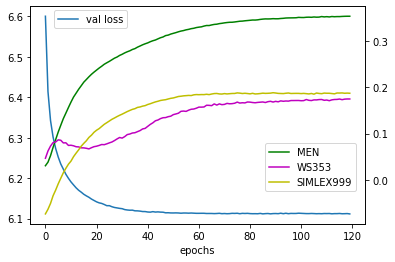

In [34]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');